In [1]:
# imports and stuff
import os
import numpy as np
from skimage import io
from glob import glob
#from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [2]:
os.chdir('/project/cper_neon_aop/cper_pdog_uas')

outDIR_base = 'cnn_results/'
prefix = 'rgb'

gt = io.imread('cnn_train_labels/rand_0_22E_random_1_labels.tif')
sp = io.imread('cnn_train_images/rand_0_22E_random_1_rgb.tif')

In [3]:
palette = {1 : (255, 255, 255), # Delineated p-dog burrows (white)
#            1 : (0, 0, 255),     # Buildings (blue)
#            2 : (0, 255, 255),   # Low vegetation (cyan)
#            3 : (0, 255, 0),     # Trees (green)
#            4 : (255, 255, 0),   # Cars (yellow)
#            5 : (255, 0, 0),     # Clutter (red)
           0 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=0)
        arr_2d[m] = i

    return arr_2d

In [4]:
# We also check that we can convert the ground truth into an array format
print(invert_palette)

array_gt = gt
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

np.zeros(array_gt.shape[:2]+(2,)).shape

{(255, 255, 255): 1, (0, 0, 0): 0}
Ground truth in numerical format has shape (256,256) : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(256, 256, 2)

In [5]:
# Parameters
WINDOW_SIZE = (256, 256)
STRIDE = 64 # Stride for testing
BASE_LR = 0.001 # Base learn rate
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
MAIN_FOLDER = "./"
BATCH_SIZE = 4 # Number of samples in a mini-batch

LABELS = ["non-road", "road"]  # Label names
N_CLASSES = len(LABELS) # Number of classes
#WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing - use for equal weighting
CACHE = True # Store the dataset in-memory

DATA_FOLDER = MAIN_FOLDER + 'cnn_train_images/{}_rgb.tif'
LABEL_FOLDER = MAIN_FOLDER + 'cnn_train_labels/{}_labels.tif'

use_cuda=False
torch_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {'num_workers': 16}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists(outDIR_base):
    os.mkdir(outDIR_base)

In [32]:
# Utils
def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2


def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0), input.size(1), -1)
        output = torch.transpose(output, 1, 2).contiguous()
        output = output.view(-1, output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target, weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))


def accuracy(array, target, label_values=None):
    #cm = confusion_matrix(target.argmax(axis=1),
    #                      array.argmax(axis=1),
    #                      range(len(label_values)))
    # Compute kappa coefficient
    #total = np.sum(cm)
    #pa = np.trace(cm) / float(total)
    #pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total * total)
    #kappa = (pa - pe) / (1 - pe)
    #return kappa
    return 100 * float(np.count_nonzero(array == target)) / target.size


def sliding_window(top, step=10, window_size=(20, 20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]


def count_sliding_window(top, step=10, window_size=(20, 20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c


def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk


def metrics(predictions, gts, id, file_location, label_values=LABELS):
    cm = confusion_matrix(
        gts,
        predictions,
        range(len(label_values)))

    print("Confusion matrix")
    print(cm)

    print("---")

    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy: {}%".format(accuracy))

    print("---")

    # Compute recall and precision
    recall = np.zeros(len(label_values))
    precision = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            recall[i] = float(cm[i, i]) / float(np.sum(cm[i, :]))
            precision[i] = float(cm[i, i]) / float(np.sum(cm[:, i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("Recall")
    for l_id, score in enumerate(recall):
        print("{}: {}".format(label_values[l_id], score))
    print("Precision")
    for l_id, score in enumerate(precision):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total * total)
    kappa = (pa - pe) / (1 - pe)
    print("Kappa: " + str(kappa))
    with open(file_location + 'Accuracy_tile_{}.txt'.format(id), "w") as text_file:
        print("Confusion matrix", file=text_file)
        print(cm, file=text_file)
        print("{} pixels processed".format(total), file=text_file)
        print("Total accuracy: {}%".format(accuracy), file=text_file)
        print("---", file=text_file)
        print("Recall", file=text_file)
        for l_id, score in enumerate(recall):
            print("{}: {}".format(label_values[l_id], score), file=text_file)
        print("Precision", file=text_file)
        for l_id, score in enumerate(precision):
            print("{}: {}".format(label_values[l_id], score), file=text_file)
        print("---", file=text_file)
        print("F1Score", file=text_file)
        for l_id, score in enumerate(F1Score):
            print("{}: {}".format(label_values[l_id], score), file=text_file)
        print("---", file=text_file)
        print("Kappa: " + str(kappa), file=text_file)
    return kappa


def class_weight(images, classes):
    # images is a list of image paths
    # classes is list of class numbers
    nclasses = len(classes)
    count = [0] * nclasses
    for i in images:
        count_tmp = [0] * nclasses
        item = io.imread(i)
        for n, c in enumerate(classes):
            count_tmp[n] = len(item[np.where(item == c)])
        count = [x + y for x, y in zip(count, count_tmp)]
    weight = [0] * nclasses
    N = float(sum(count))
    for n, c in enumerate(classes):
        weight[n] = 1.0 - float(count[n])/N
    weight = [round(x, 4) for x in weight]
    return torch.tensor(weight)


class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                 cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()

        self.augmentation = augmentation
        self.cache = cache

        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}

    def __len__(self):
        # Default epoch size is 10 000 samples
        return len(self.label_files)

    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True

        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))

        return tuple(results)

    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)

        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1 / 255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2, 0, 1)), dtype='float64')
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else:
            # Labels are converted from RGB to their numeric values
            label = np.asarray(io.imread(self.label_files[random_idx]), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        #x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        #data_p = data[:, x1:x2, y1:y2]
        #label_p = label[x1:x2, y1:y2]
        #data_p = data
        #label_p = label
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data, label)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p).type(torch.float64),
                torch.from_numpy(label_p).type(torch.int64))


class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)

    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)

    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)

        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)

        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)

        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)

        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)

        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))

        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))

        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))

        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))

        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x), dim=1)
        return x


In [33]:
#net = SegNet().double()
net = SegNet().double().to(device)
if use_cuda:
    net = net.cuda()

In [53]:
#net.load_state_dict(mapped_weights)
vgg16_weights.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.20.weight', 'features.20.bias', 'features.21.weight', 'features.21.bias', 'features.21.running_mean', 'features.21.running_var', 'features.24.weight', 'features.2

In [51]:
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        if "num_batches_tracked" in k_segnet:
            continue
        else:
            mapped_weights[k_segnet] = vgg16_weights[k_vgg]
            print("Mapping {} to {}".format(k_vgg, k_segnet))

try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    print('error')
    #pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping features.11.bias to conv2_2.weight
Mapping features.11.running_mean to conv2_2.bias
Mapping features.11.running_var to c

In [35]:
import re
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[-3:]) for y in all_ids]))

In [36]:
import pandas as pd
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [37]:
all_files = glob(DATA_FOLDER.replace('{}', '*'))
train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(train_tiles))

train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in train_tiles]
test_ids = list(set(all_ids) - set(train_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [38]:
#WEIGHTS = class_weight(images=train_files, classes=[0, 1])
WEIGHTS = torch.tensor([0.167, 0.833])

In [39]:
#train_ids

In [40]:
random.seed(456)
train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **torch_kwargs)

In [41]:
base_lr = BASE_LR
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [2, 5, 7], gamma=0.1)

In [42]:
np.ceil(len(train_set)/BATCH_SIZE)

54.0

In [43]:
def test(net, test_ids, all=False, stride=STRIDE, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, show=False):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    #     eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []

    # Switch the network to inference mode
    net.eval()

    for img, gt, id_ in zip(test_images, test_labels, test_ids):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(
                grouper(batch_size, sliding_window(img, step=stride, window_size=window_size))):
            if show:
                print(coords)
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                _pred = np.argmax(pred, axis=-1)
                fig = plt.figure()
                fig.add_subplot(1, 3, 1)
                plt.imshow(np.asarray(255 * img, dtype='uint8'))
                fig.add_subplot(1, 3, 2)
                plt.imshow(_pred, cmap=plt.cm.gray, vmin=0, vmax=1)
                fig.add_subplot(1, 3, 3)
                plt.imshow(gt, cmap=plt.cm.gray, vmin=0, vmax=1)
                #clear_output()
                if show:
                    plt.show()
                plt.close()

            # Build the tensor
            image_patches = [np.copy(img[x:x + w, y:y + h]).transpose((2, 0, 1)) for x, y, w, h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = torch.from_numpy(image_patches).to(dtype=torch.double)

            # Do the inference
            net = net
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()

            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1, 2, 0))
                pred[x:x + w, y:y + h] += out
            del (outs)

        pred_log_softmax = pred
        pred_prob = np.exp(pred)
        #         pred_prob[:,:,1] = 1.0 + pred_prob[:,:,1]
        pred = np.argmax(pred, axis=-1)

        # Save/display the result
        #clear_output()
        fig = plt.figure()
        fig.add_subplot(1, 3, 1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        if not os.path.exists(outDIR_base + '/spectral_img/'):
            os.mkdir(outDIR_base + '/spectral_img/')
        if not os.path.exists(outDIR_base + '/predictions/'):
            os.mkdir(outDIR_base + '/predictions/')
        if not os.path.exists(outDIR_base + '/ground_truths/'):
            os.mkdir(outDIR_base + '/ground_truths')
        io.imsave(outDIR_base + '/spectral_img/original_tile_{}.png'.format(id_),
                  np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1, 3, 2)
        plt.imshow(pred, cmap=plt.cm.gray, vmin=0, vmax=1)
        io.imsave(outDIR_base + '/predictions/inference_tile_{}.png'.format(id_),
                  convert_to_color(pred))
        fig.add_subplot(1, 3, 3)
        plt.imshow(gt, cmap=plt.cm.gray, vmin=0, vmax=1)
        io.imsave(outDIR_base + '/ground_truths/ground_truth_{}.png'.format(id_),
                  convert_to_color(gt))
        if show:
            plt.show()
        plt.close()

        all_preds.append(pred)
        all_gts.append(gt)

        #clear_output()
        # Compute some metrics
        if not os.path.exists(outDIR_base + '/predictions/'):
            os.mkdir(outDIR_base + '/predictions/')
        metrics(pred.ravel(), gt.ravel(), id=id_, file_location=outDIR_base + '/predictions/')
        # accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
        with open(outDIR_base + '/predictions/test_{}.txt'.format(id_), 'w') as outfile:
            # I'm writing a header here just for the sake of readability
            # Any line starting with "#" will be ignored by numpy.loadtxt
            outfile.write('# Array shape: {0}\n'.format(pred_log_softmax.shape))

            # Iterating through a ndimensional array produces slices along
            # the last axis. This is equivalent to data[i,:,:] in this case
            for data_slice in pred_log_softmax:
                # The formatting string indicates that I'm writing out
                # the values in left-justified columns 7 characters in width
                # with 2 decimal places.
                np.savetxt(outfile, data_slice, fmt='%-7.2f')

                # Writing out a break to indicate different slices...
                outfile.write('# New slice\n')
    if all:
        return all_preds, all_gts
    else:
        return

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch=5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.to(dtype=torch.double)

    criterion = nn.NLLLoss(weight=weights)
    iter_ = 0

    for e in range(1, epochs + 1):
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(dtype=torch.double), target.to(dtype=torch.long)
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()

            losses[iter_] = loss.data
            mean_losses[iter_] = np.mean(losses[max(0, iter_ - 100):iter_])

            if iter_ % 10 == 0:
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader)))
                #clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0], (1, 2, 0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(gt, cmap=plt.cm.gray, vmin=0, vmax=1)
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred, cmap=plt.cm.gray, vmin=0, vmax=1)
                plt.show()
                plt.close()
            iter_ += 1
            del (data, target, loss)
            
            if scheduler is not None:
                scheduler.step()

        if e % save_epoch == 0 or e == epochs:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            if not os.path.exists(outDIR_base + '/tmp'):
                os.mkdir(outDIR_base + '/tmp')
            torch.save(net.state_dict(), outDIR_base + '/tmp/segnet128_epoch{}_{}'.format(e, acc))
    if not os.path.exists(outDIR_base + '/segnet_final'):
        os.mkdir(outDIR_base + '/segnet_final')
    torch.save(net.state_dict(), outDIR_base + '/segnet_final/segnet_final')


/project/cper_neon_aop/conda_envs/cnn_segnet_env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/project/cper_neon_aop/conda_envs/cnn_segnet_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/project/cper_neon_aop/conda_envs/cnn_segnet_env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train (epoch 1/5) [0/54 (0%)]


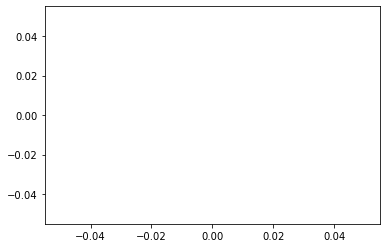

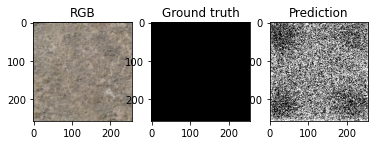

Train (epoch 1/5) [10/54 (19%)]


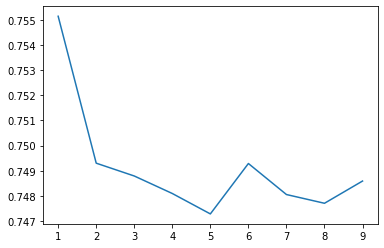

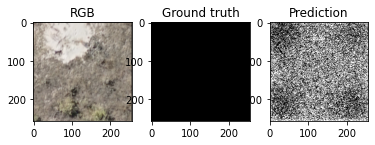

Train (epoch 1/5) [20/54 (37%)]


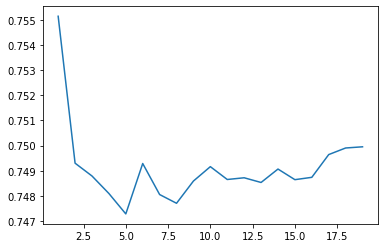

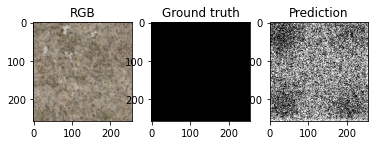

Train (epoch 1/5) [30/54 (56%)]


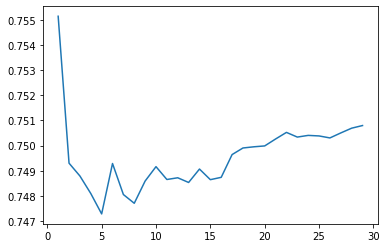

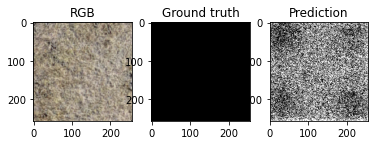

Train (epoch 1/5) [40/54 (74%)]


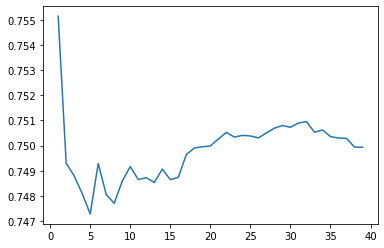

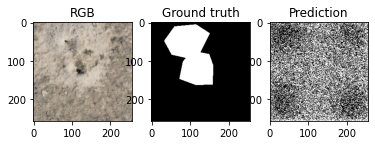

Train (epoch 1/5) [50/54 (93%)]


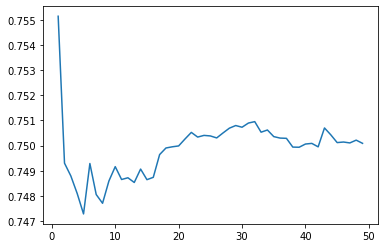

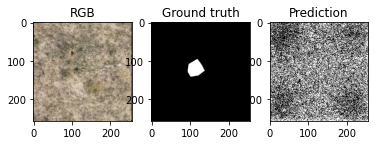

/local/bgfs/sean.kearney/7865530/ipykernel_167961/56307706.py:71: UserWarning: cnn_results//predictions/inference_tile_rand_4_22E_random_9.png is a low contrast image
  io.imsave(outDIR_base + '/predictions/inference_tile_{}.png'.format(id_),
/local/bgfs/sean.kearney/7865530/ipykernel_167961/56307706.py:75: UserWarning: cnn_results//ground_truths/ground_truth_rand_4_22E_random_9.png is a low contrast image
  io.imsave(outDIR_base + '/ground_truths/ground_truth_{}.png'.format(id_),


TypeError: confusion_matrix() takes 2 positional arguments but 3 were given

In [44]:
train(net, optimizer, 5, scheduler, weights=WEIGHTS, save_epoch=1)

In [ ]:
#1 / 255 * np.asarray(io.imread(train_set.data_files[0]).transpose((2, 0, 1)), dtype='float64')
test = 1 / 255 * np.asarray(io.imread(train_set.label_files[0]), dtype='int64')
test.shape